# Risk Analysis Pipeline

This notebook performs comprehensive risk analysis on survey data, including:
- Regional and sector analysis
- Suspect operations detection
- Compliance monitoring
- Risk assessment and scoring

## Setup Instructions

1. Ensure your data is in the `data/raw` directory
2. Install required packages: `pip install -r requirements.txt`
3. Run cells sequentially

## 1. Setup and Imports

In [4]:
# If you have conda installed, you can run the following commands:
# conda env create -f environment.yml
# conda activate 

# Add src directory to Python path
import os
import sys
src_dir = os.path.join(os.getcwd(), 'src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [5]:
# Add src necessary directories
os.makedirs(os.path.join(os.getcwd(), 'data/processed'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'outputs'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'outputs/charts'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'outputs/tables'), exist_ok=True)


# Import required modules
from src.data_loader import DataLoader
from src.visulaizer import Visualizer
from src.risk_analyzer import RiskAnalyzer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All modules imported successfully")

✅ All modules imported successfully


## 2. Data Loading and Preparation

In [ ]:
# Initialize data loader
data_loader = DataLoader(xlsx_file_dir="data/raw", output_dir="data/processed")

# Uncomment the line below if you need to merge raw data files first
data_loader.merge_all_data()

print("✅ Data loader initialized")

✅ Data loader initialized


## 3. Regional and Sector Analysis

First, let's examine the distribution of survey responses across different regions and sectors.

In [7]:
# Load data for regional analysis
regional_data = data_loader.open_merged_data(columns=["SURVEY_ID", "SECTOR", "REGION"])

# Display basic info
print(f"Dataset shape: {regional_data.shape}")
print(f"\nColumns: {list(regional_data.columns)}")
print(f"\nFirst few rows:")
regional_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/merged_data.xlsx'


📊 Regional Distribution Summary:
REGION
LU        9595
NON LU    4613
Name: count, dtype: int64

📊 Sector Distribution Summary:
SECTOR
IMMO       8207
ECO        5175
SERVICE     838
Name: count, dtype: int64


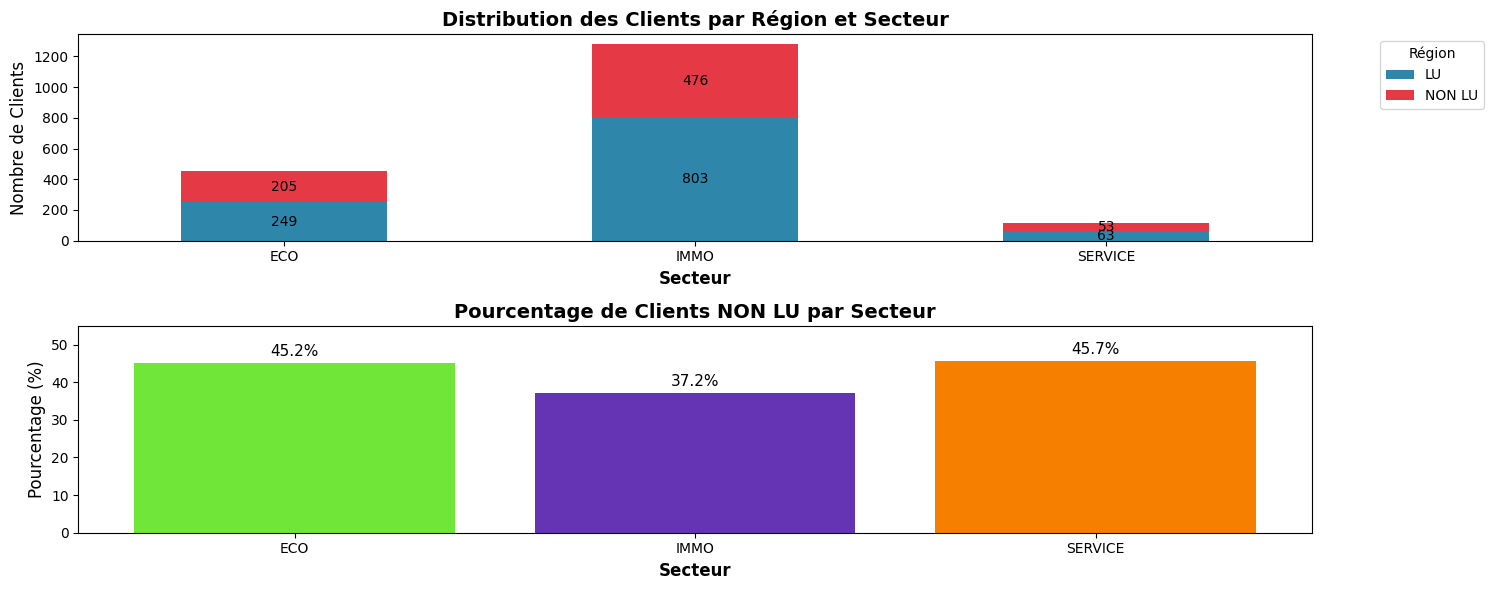

In [ ]:
# Create regional visualization
visualizer = Visualizer(regional_data)
visualizer.plot_region_by_sector()

# Display summary statistics
print("\n📊 Regional Distribution Summary:")
print(regional_data['REGION'].value_counts())
print("\n📊 Sector Distribution Summary:")
print(regional_data['SECTOR'].value_counts())

## 4. Suspect Operations Analysis

Analyzing patterns in business relationship refusals, terminations, and suspicious transactions.

In [ ]:
# Load data for suspect operations analysis
suspect_data = data_loader.open_merged_data(
    columns=[
        "SURVEY_ID",
        "SECTOR",
        "BU_REL_REFUSAL",
        "BU_REL_TERM",
        "SUSP_TRANS_SURVEY",
    ]
)

print(f"Suspect operations dataset shape: {suspect_data.shape}")
suspect_data.head()

Suspect operations dataset shape: (14220, 5)


,SURVEY_ID,SECTOR,BU_REL_REFUSAL,BU_REL_TERM,SUSP_TRANS_SURVEY
0,2925330,ECO,None,None,None
1,2925330,ECO,None,None,None
2,2925330,ECO,None,None,None
3,2925420,SERVICE,None,None,None
4,2925420,SERVICE,None,None,None



🚨 Suspect Operations Summary:

BU_REL_REFUSAL:
BU_REL_REFUSAL
N    13267
Y      953
Name: count, dtype: int64

BU_REL_TERM:
BU_REL_TERM
N    13450
Y      770
Name: count, dtype: int64

SUSP_TRANS_SURVEY:
SUSP_TRANS_SURVEY
N    13246
Y      974
Name: count, dtype: int64


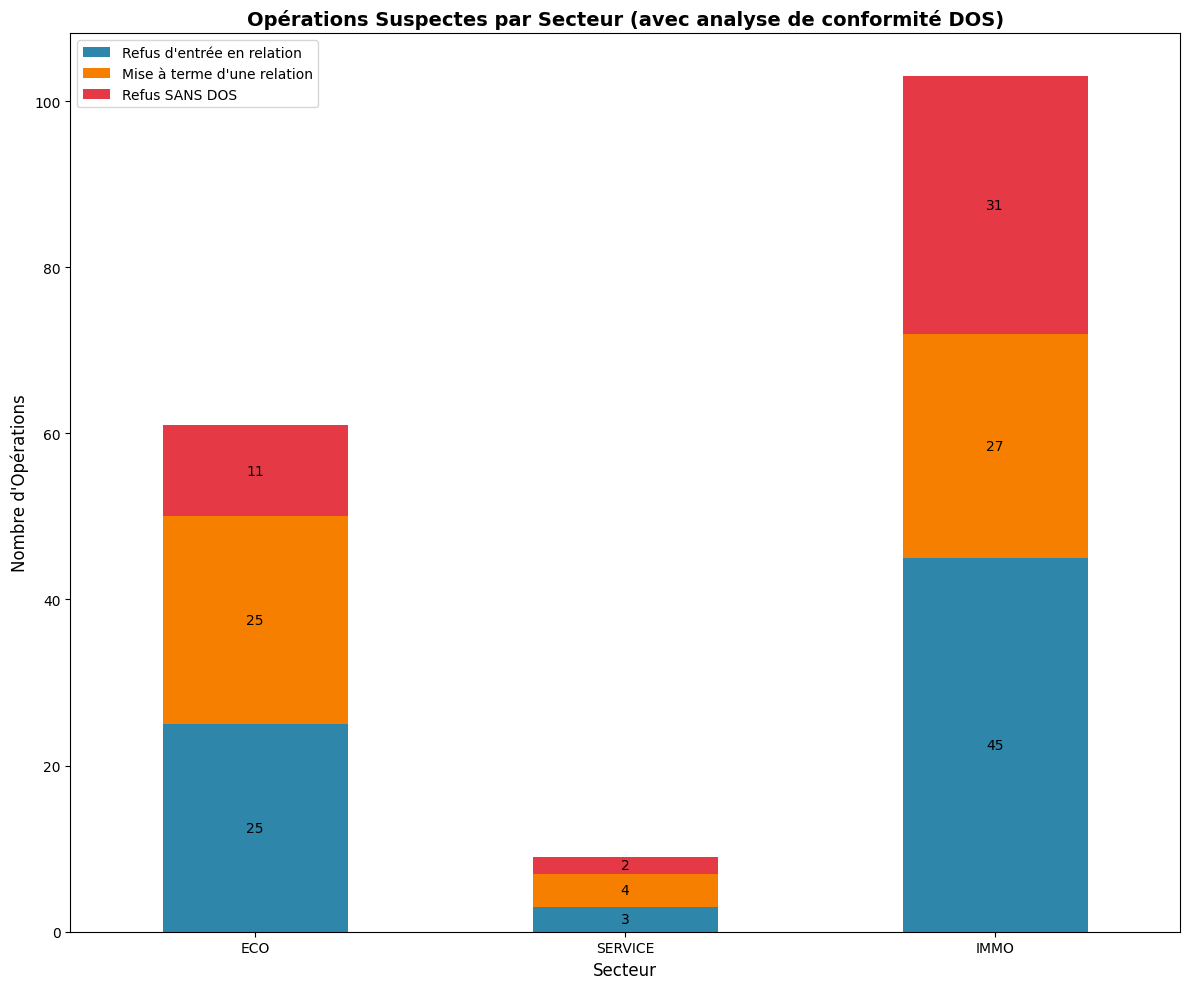

In [ ]:
# Visualize suspect operations by sector
visualizer = Visualizer(suspect_data)
visualizer.plot_suspect_operations_by_sector()

# Summary statistics for suspect operations
print("\n🚨 Suspect Operations Summary:")
for col in ["BU_REL_REFUSAL", "BU_REL_TERM", "SUSP_TRANS_SURVEY"]:
    if col in suspect_data.columns:
        print(f"\n{col}:")
        print(suspect_data[col].value_counts())

## 5. Identification Compliance Analysis

Examining client and beneficiary identification compliance across sectors.

In [ ]:
# Load identification compliance data
id_compliance_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "CLIENT_ID_STATUS", "BENIFICIARY_ID_STATUS"]
)

print(f"ID compliance dataset shape: {id_compliance_data.shape}")
id_compliance_data.head()

ID compliance dataset shape: (14220, 4)


,SURVEY_ID,SECTOR,CLIENT_ID_STATUS,BENIFICIARY_ID_STATUS
0,2925330,ECO,SIMPLE,None
1,2925330,ECO,SIMPLE,None
2,2925330,ECO,SIMPLE,None
3,2925420,SERVICE,AVANCEE,AVANCEE
4,2925420,SERVICE,AVANCEE,AVANCEE



🆔 Identification Compliance Summary:

Client ID Status:
CLIENT_ID_STATUS
AVANCEE    9894
SIMPLE     3984
Name: count, dtype: int64

Beneficiary ID Status:
BENIFICIARY_ID_STATUS
AVANCEE    9537
SIMPLE     3309
Name: count, dtype: int64


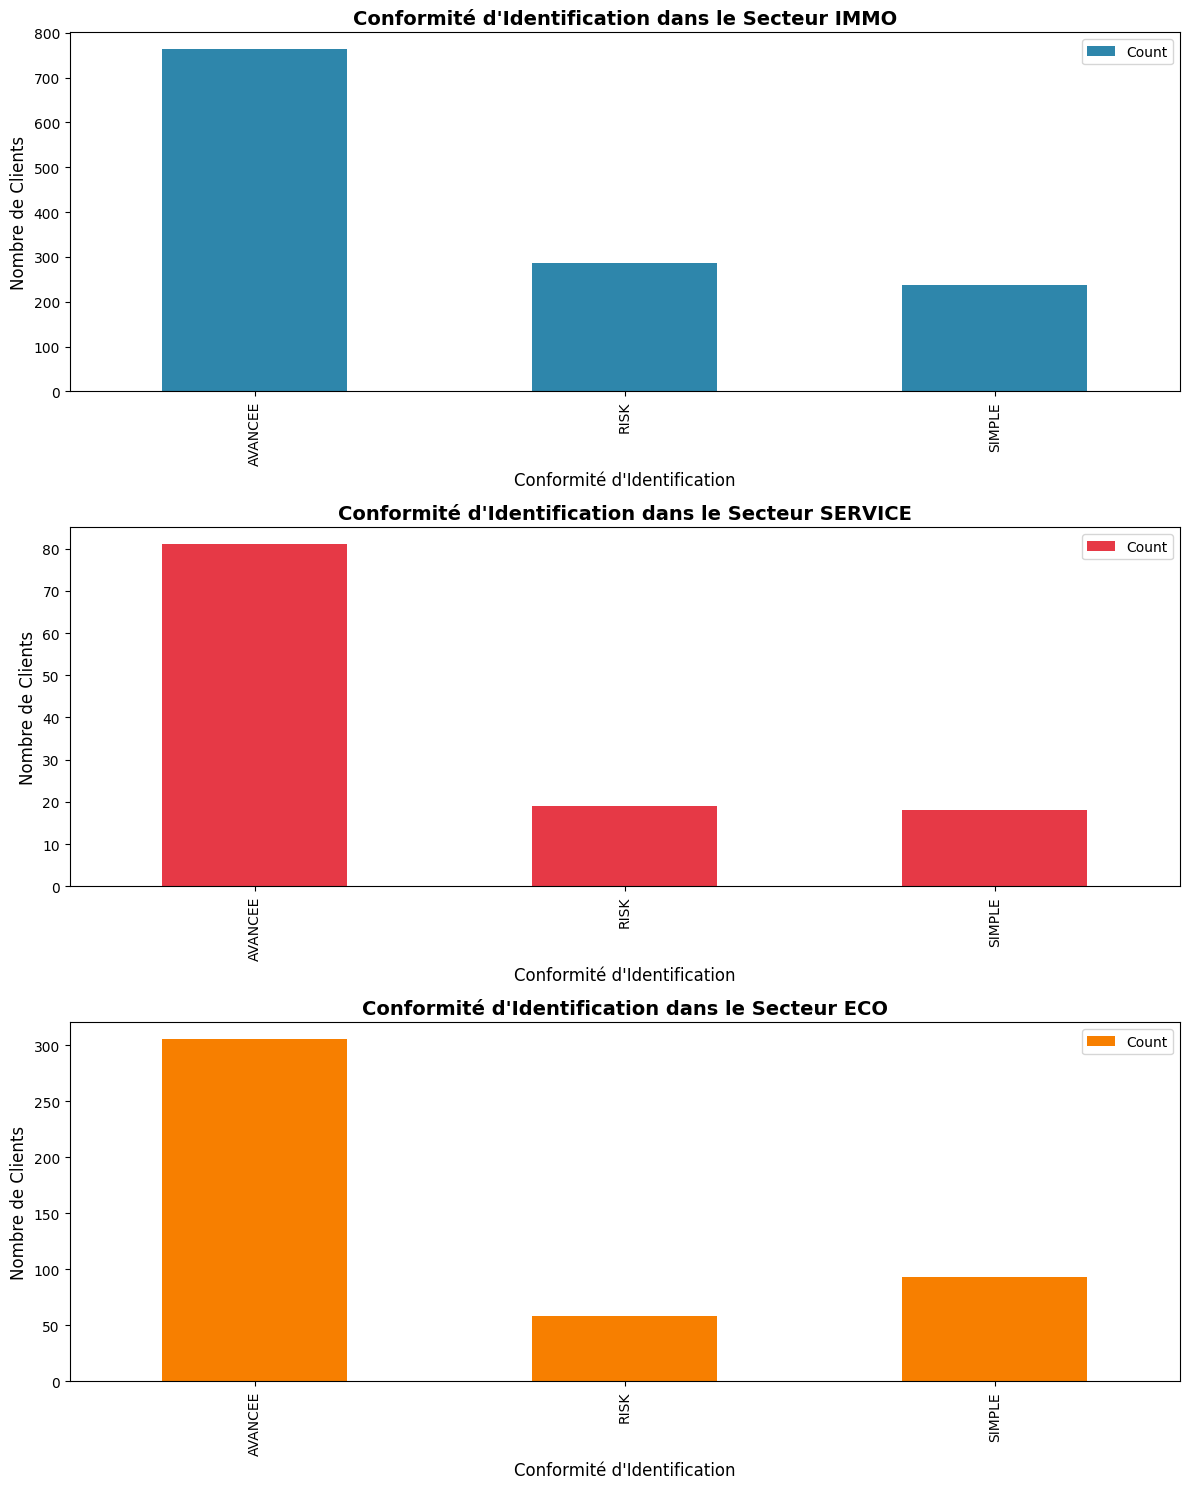

In [ ]:
# Visualize identification compliance
visualizer = Visualizer(id_compliance_data)
visualizer.plot_identification_compliance()

# Compliance summary
print("\n🆔 Identification Compliance Summary:")
print("\nClient ID Status:")
print(id_compliance_data['CLIENT_ID_STATUS'].value_counts())
print("\nBeneficiary ID Status:")
print(id_compliance_data['BENIFICIARY_ID_STATUS'].value_counts())

## 6. Document Archiving Compliance

Analyzing document archiving practices across different sectors.

In [ ]:
# Load document archiving data
archiving_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "DOCUMENT_ARCHIVING"]
)

print(f"Document archiving dataset shape: {archiving_data.shape}")
archiving_data.head()

Document archiving dataset shape: (14220, 3)


,SURVEY_ID,SECTOR,DOCUMENT_ARCHIVING
0,2925330,ECO,None
1,2925330,ECO,None
2,2925330,ECO,None
3,2925420,SERVICE,5A
4,2925420,SERVICE,5A



📁 Document Archiving Compliance Summary:
DOCUMENT_ARCHIVING
5A+    6393
5A     4889
5A-     753
3A-     575
Name: count, dtype: int64


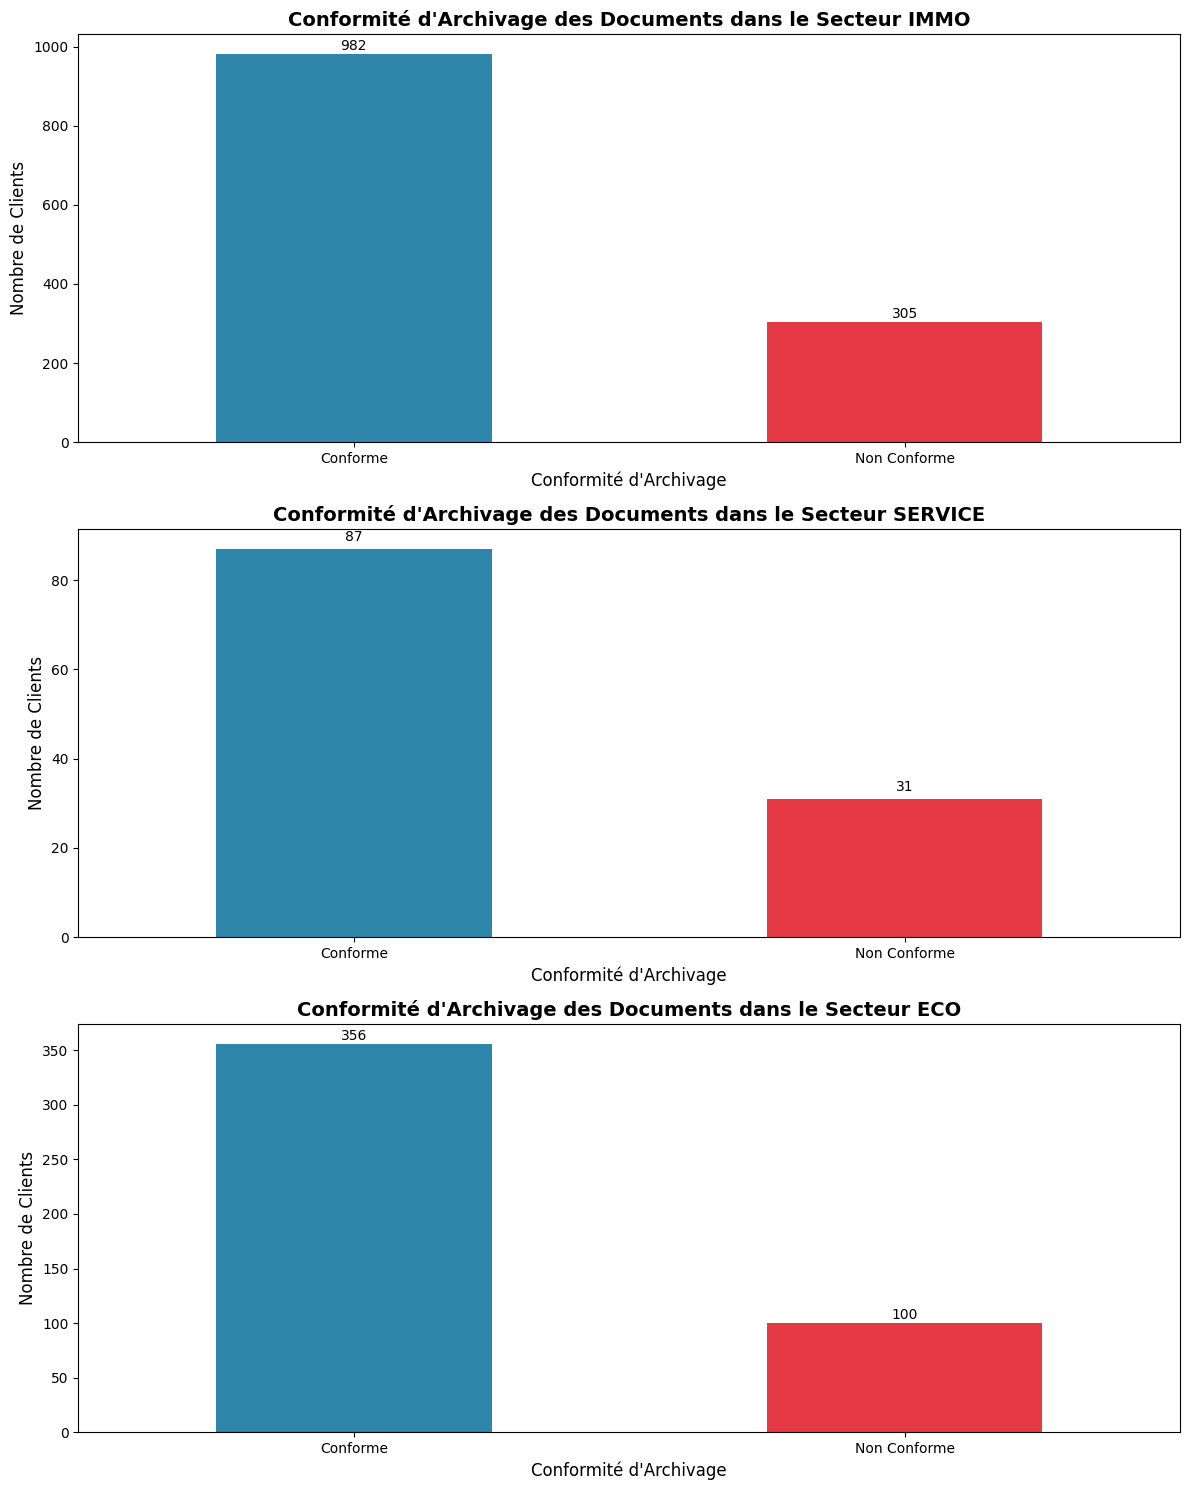

In [ ]:
# Visualize document archiving compliance
visualizer = Visualizer(archiving_data)
visualizer.plot_document_archiving_compliance_by_sector()

# Document archiving summary
print("\n📁 Document Archiving Compliance Summary:")
print(archiving_data['DOCUMENT_ARCHIVING'].value_counts())

## 7. Cash Transactions Analysis

Examining payment methods and cash transaction patterns by sector.

In [ ]:
# Load payment method data
payment_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "PAYMENT_METHOD"]
)

print(f"Payment method dataset shape: {payment_data.shape}")
payment_data.head()

Payment method dataset shape: (14220, 3)


,SURVEY_ID,SECTOR,PAYMENT_METHOD
0,2925330,ECO,VIR
1,2925330,ECO,VIR
2,2925330,ECO,VIR
3,2925420,SERVICE,VIR
4,2925420,SERVICE,VIR



💰 Payment Method Summary:
PAYMENT_METHOD
VIR       12924
CASH        653
AUTRE       564
CHEQUE       67
Name: count, dtype: int64


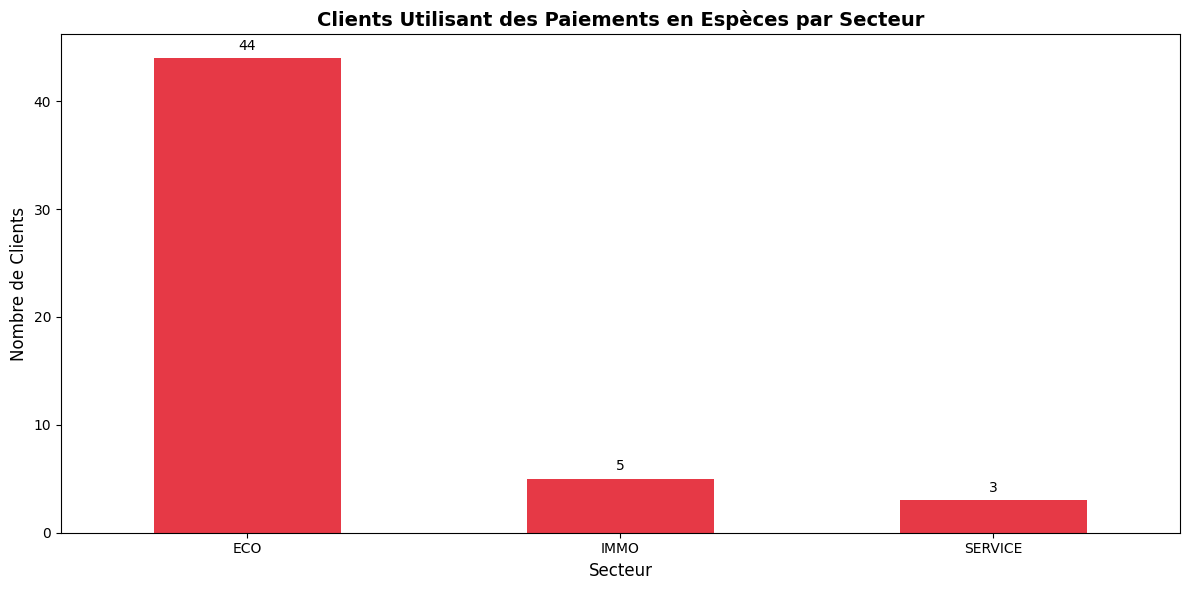

In [ ]:
# Visualize cash transactions by sector
visualizer = Visualizer(payment_data)
visualizer.plot_cash_transactions_by_sector()

# Payment method summary
print("\n💰 Payment Method Summary:")
print(payment_data['PAYMENT_METHOD'].value_counts())

## 8. High-Risk Revenue Analysis

Analyzing revenue types and transaction volumes to identify high-risk patterns.

In [ ]:
# Load revenue and transaction data
revenue_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "REVENUE_KIND", "NB_TRANSACTIONS"]
)

print(f"Revenue analysis dataset shape: {revenue_data.shape}")
revenue_data.head()

Revenue analysis dataset shape: (14220, 4)


,SURVEY_ID,SECTOR,REVENUE_KIND,NB_TRANSACTIONS
0,2925330,ECO,ECO_COMPTABILIT,0.0
1,2925330,ECO,ECO_COMPTABILIT,0.0
2,2925330,ECO,ECO_COMPTABILIT,0.0
3,2925420,SERVICE,SERV_COMPTABILI,0.0
4,2925420,SERVICE,SERV_COMPTABILI,0.0


In [ ]:
# Summarize high-risk revenue by sector
visualizer = Visualizer(revenue_data)
visualizer.summarize_high_risk_revenue_by_sector()

# Revenue summary statistics
print("\n📈 Revenue Analysis Summary:")
print("\nRevenue Types:")
print(revenue_data['REVENUE_KIND'].value_counts())
print("\nTransaction Volume Statistics:")
print(revenue_data['NB_TRANSACTIONS'].describe())

75th percentile: 61.0
Total IMMO clients: 767
Clients > threshold: 191
Clients >= threshold: 193

Clients with 50-70 transactions: 54

📈 Revenue Analysis Summary:

Revenue Types:
REVENUE_KIND
IMMO_ACHAT_VENT    3432
IMMO_AUTRE         2652
ECO_COMPTABILIT    1794
IMMO_LOCATION      1746
ECO_AUTRE          1011
ECO_FISCALITE       732
ECO_PAYROLL         714
ECO_CONSEIL_GES     465
ECO_CREATION_SO     414
SERV_AUTRE          276
SERV_BUREAU_EQU     162
SERV_COMPTABILI     120
SERV_SECRETARIA     114
SERV_FONCTION        81
SERV_CREATION_S      42
SERV_SIEGE           12
SERV_BUREAU_VIR       6
Name: count, dtype: int64

Transaction Volume Statistics:
count    1.377300e+04
mean     4.727632e+02
std      1.428194e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+00
max      1.025000e+06
Name: NB_TRANSACTIONS, dtype: float64


## 9. Comprehensive Risk Assessment

Computing overall risk scores and identifying high-risk clients based on multiple factors.

In [ ]:
# Initialize risk analyzer
risk_analyzer = RiskAnalyzer(data_loader)

# Calculate risk scores
print("🔍 Calculating comprehensive risk scores...")
risk_data = risk_analyzer.calculate_risk_scores()

print(f"\nRisk assessment dataset shape: {risk_data.shape}")
print(f"\nColumns in risk dataset: {list(risk_data.columns)}")
risk_data.head()

🔍 Calculating comprehensive risk scores...

Risk assessment dataset shape: (14220, 12)

Columns in risk dataset: ['SURVEY_ID', 'SECTOR', 'REGION_RISK', 'BU_REL_REFUSAL', 'BU_REL_TERM', 'IDENTIFICATION_COMPLIANCE', 'ARCHIVING_COMPLIANCE', 'PAYMENT_METHOD', 'REVENUE_KIND', 'NB_TRANSACTIONS', 'RISK_SCORE', 'RISK_CATEGORY']


,SURVEY_ID,SECTOR,REGION_RISK,BU_REL_REFUSAL,BU_REL_TERM,IDENTIFICATION_COMPLIANCE,ARCHIVING_COMPLIANCE,PAYMENT_METHOD,REVENUE_KIND,NB_TRANSACTIONS,RISK_SCORE,RISK_CATEGORY
0,2925330,ECO,LU,N,N,RISK,Non Conforme,VIR,ECO_COMPTABILIT,0.0,2,Medium
1,2925330,ECO,LU,N,N,RISK,Non Conforme,VIR,ECO_COMPTABILIT,0.0,2,Medium
2,2925330,ECO,LU,N,N,RISK,Non Conforme,VIR,ECO_COMPTABILIT,0.0,2,Medium
3,2925420,SERVICE,LU,N,N,AVANCEE,Conforme,VIR,SERV_COMPTABILI,0.0,0,Low
4,2925420,SERVICE,LU,N,N,AVANCEE,Conforme,VIR,SERV_COMPTABILI,0.0,0,Low


RISK_CATEGORY
Low       1407
Medium     433
High        21
Name: count, dtype: int64
SECTOR
IMMO       1287
ECO         456
SERVICE     118
Name: count, dtype: int64
SECTOR   RISK_CATEGORY
ECO      High               5
         Low              342
         Medium           109
IMMO     High              15
         Low              982
         Medium           290
SERVICE  High               1
         Low               83
         Medium            34
dtype: int64


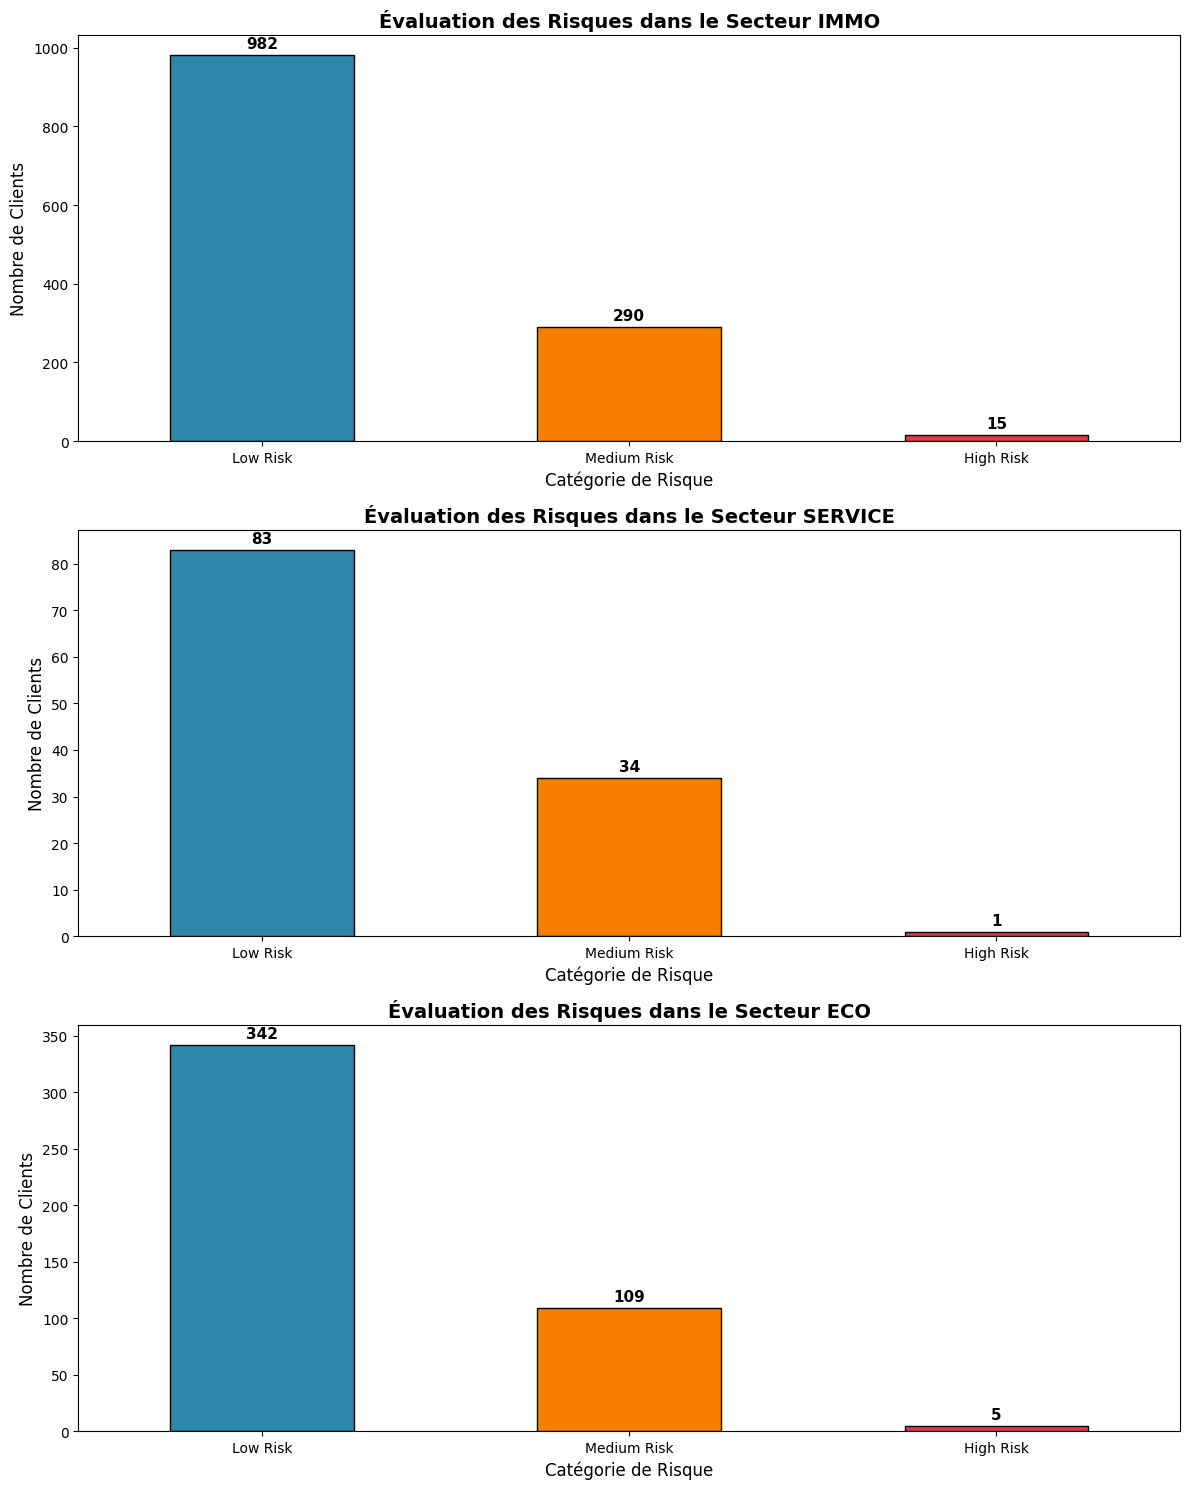

In [ ]:
# Visualize risk assessment by sector
visualizer = Visualizer(risk_data)
visualizer.plot_risk_assesment_by_sector()

# Risk score statistics
if 'risk_score' in risk_data.columns:
    print("\n⚠️ Risk Score Statistics:")
    print(risk_data['risk_score'].describe())
    
    print("\nRisk Distribution by Sector:")
    if 'SECTOR' in risk_data.columns:
        risk_by_sector = risk_data.groupby('SECTOR')['risk_score'].agg(['mean', 'median', 'std', 'count'])
        print(risk_by_sector)

In [ ]:
# Identify high-risk clients
print("🚨 Identifying high-risk clients...")
high_risk_clients = risk_analyzer.find_high_risk_clients()

if high_risk_clients is not None:
    print(f"\nNumber of high-risk clients identified: {len(high_risk_clients)}")
    print("\nHigh-risk clients preview:")
    print(high_risk_clients["SURVEY_ID"].head(10))
else:
    print("No high-risk clients data returned")

🚨 Identifying high-risk clients...

Number of high-risk clients identified: 21

High-risk clients preview:
      SURVEY_ID SECTOR REGION_RISK BU_REL_REFUSAL BU_REL_TERM  \
226     3810036   IMMO      NON LU              Y           N   
673     4688996   IMMO      NON LU              Y           N   
1316    6416017    ECO      NON LU              Y           N   
5257    8431270    ECO      NON LU              Y           Y   
5765    9847161    ECO      NON LU              Y           Y   
5826    9887892    ECO      NON LU              N           N   
6072   10004382   IMMO      NON LU              Y           Y   
6084   10004719   IMMO      NON LU              Y           Y   
6371   10162277   IMMO          LU              Y           Y   
6623   10842428   IMMO      NON LU              Y           N   

     IDENTIFICATION_COMPLIANCE ARCHIVING_COMPLIANCE PAYMENT_METHOD  \
226                       RISK         Non Conforme            VIR   
673                       RISK       

## 10. Summary and Key Findings

Let's summarize the key insights from our risk analysis pipeline.

In [ ]:
# Generate summary statistics
print("📋 RISK ANALYSIS PIPELINE SUMMARY")
print("=" * 50)

# Basic dataset info
total_surveys = len(risk_data) if 'SURVEY_ID' in risk_data.columns else "Unknown"
unique_sectors = risk_data['SECTOR'].nunique() if 'SECTOR' in risk_data.columns else "Unknown"

print(f"📊 Total surveys analyzed: {total_surveys}")
print(f"📈 Unique sectors: {unique_sectors}")

if 'risk_score' in risk_data.columns:
    avg_risk = risk_data['risk_score'].mean()
    high_risk_threshold = risk_data['risk_score'].quantile(0.8)  # Top 20%
    high_risk_count = len(risk_data[risk_data['risk_score'] > high_risk_threshold])
    
    print(f"⚠️ Average risk score: {avg_risk:.2f}")
    print(f"🚨 High-risk entities (top 20%): {high_risk_count}")
    print(f"🔢 High-risk threshold: {high_risk_threshold:.2f}")

print("\n✅ Analysis completed successfully!")
print("\n💡 Next steps:")
print("   • Review high-risk clients for further investigation")
print("   • Implement monitoring for identified risk patterns")
print("   • Consider additional data sources for enhanced analysis")

📋 RISK ANALYSIS PIPELINE SUMMARY
📊 Total surveys analyzed: 14220
📈 Unique sectors: 3

✅ Analysis completed successfully!

💡 Next steps:
   • Review high-risk clients for further investigation
   • Implement monitoring for identified risk patterns
   • Consider additional data sources for enhanced analysis
